In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# NLP - review

## Loading

In [2]:
import json
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import nltk
from nltk.tag import pos_tag
import spacy
from spacy.tokens.doc import Doc
from spacy.vocab import Vocab

import re
from spacy.tokenizer import Tokenizer

# pip install -U spacy
# python -m spacy download en_core_web_sm
import random

# stemming
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer

# linguistic pattern
from spacy.matcher import Matcher

from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# dataset splitting
from sklearn.model_selection import train_test_split

# onehot encoding
from sklearn.preprocessing import OneHotEncoder
import collections
from argparse import Namespace
import os
import string

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from torch.nn.utils import rnn as rnn_utils

In [3]:
data_review = pd.read_csv("/content/drive/MyDrive/summer_project_2021/airbnb/reviews_full.csv")
nlp = spacy.load('en_core_web_sm')

## Data Exploration

In [4]:
data_review.head()
data_review.shape
# (220969, 6)

(220969, 6)

In [5]:
data_review.keys()

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

reviews will be checked based on different year and it will be start from the latest year which is 2021.


In [6]:
data_review[['year', 'month']] = data_review['date'].str.split('-', 1, expand=True)

In [7]:
set(data_review.year)

{'2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021'}

## Process Dataset

In [60]:
df = data_review[['date', 'year', 'month', 'comments']]
# the most focus column is comment, so remove rows that their comments are NaN
df = df[df.comments.notna()]
df.head()
df.shape
# (220549, 4)
# 420 rows are removed

(220549, 4)

In [ ]:
# !pip install langdetect
from langdetect import detect

In [112]:
review_2021 = df[df.year == '2021'].reset_index()
review_2021_en = []
for i in range(len(review_2021)):
  # use try+except to skip the 'No features in text' error (emoji/./or other unrecognise words) in the loop
  # detect('⭐️⭐️⭐️⭐️⭐️')
  try:
    if detect(review_2021.comments[i]) == 'en':
      review_2021_en.append(review_2021.comments[i])
  except:
    pass

In [120]:
# len(review_2021_en)
# 39478
# there are 39478 reviews in year 2021 and due to the long execution time, I ransom select 1000 rows
review_2021_en_1000 = random.sample(review_2021_en, 1000)

### Tokenize

In [10]:
import nltk
nltk.download('punkt') # sentence tokenize
nltk.download('average_perceptron_tagger') # POS Tagging
nltk.download('maxent_ne_chunker') # Named Entity Chunking
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Error loading average_perceptron_tagger: Package
[nltk_data]     'average_perceptron_tagger' not found in index
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [123]:
prefix_re = spacy.util.compile_prefix_regex(nlp.Defaults.prefixes)
suffix_re = spacy.util.compile_suffix_regex(nlp.Defaults.suffixes)
infix_re = re.compile(r'''[-~]''')
def customize_tokenizer(nlp):
  # Adds support to use `-` as the delimiter for tokenization
    return Tokenizer(nlp.vocab, prefix_search=prefix_re.search,
                      suffix_search=suffix_re.search,
                      infix_finditer=infix_re.finditer,
                      token_match=None
                      )

In [124]:
nlp.tokenizer = customize_tokenizer(nlp)

In [125]:
# review_token = []
# for sentence in review_2021_en_1000:
#     words = nltk.word_tokenize(sentence)
#     tagged_words = nltk.pos_tag(words)
#     ne_tagged_words = nltk.ne_chunk(tagged_words)
#     review_token = review_token + [ne_tagged_words]

# # len(review_token)
# # 1000

In [223]:
doc = nlp(' '.join(review_2021_en_1000).replace('br/', ' ').replace('<', ' ').replace('>', ' '))

In [224]:
doc

Nice, cozy apartment. İt is right next to the metro so commuting is easy.    The building is top level with great amenities. Everyone is kind and helpful. Thank you Ogün for hosting us She accepted booking but told me not to go the day before arrival. Said she couldn't cancel but over 10 days and hasn't replied about compensation The place was too small. The shower place was right in front of toilet and there wasn’t a separate place for the shower. Instead it was right in front of the toilet that it was so unhygienic. So be aware for those who want to book this place. The WiFi was unreliable. The WiFi on the main bed area was too slow or not there at all. We had to be away from the bed every time if we needed to reconnect to the WiFi.       Also, our original stay was 29 days, but we changed it to 11 days stay. Before changing our dates we’re told by the host that we will get half of the refund which we never did. Airbnb told us to speak to the host, but he never replied back. He basic

### Lemmatize

In contrast to stemming, lemmatization looks beyond word reduction and considers a language’s full vocabulary to apply a morphological analysis to words. The lemma of ‘was’ is ‘be’ and the lemma of ‘mice’ is ‘mouse’. Lemmatization is typically seen as much more informative than simple stemming, which is why Spacy has opted to only have Lemmatization available instead of Stemming

In [225]:
def lemmatize(data):
    lemma = ""
    for i in data:
        lemma = lemma + ' ' + i.lemma_
    return lemma

In [226]:
lemma = lemmatize(doc)
# lemma[0:10] ==  nice , co
lemma2 = nlp(lemma)
# lemma2[0:10] ==  nice , cozy apartment . i̇t be right next

### Remove stop words

In [130]:
# lowercase
def lower_case(data):
    lower = []
    for i in data:
        lower = lower + [str(i).lower()]
    return lower

In [175]:
# lower_case(lemma2)

In [210]:
# stopwords
from nltk.corpus import stopwords
# print(stopwords.words('english'))
# 179
def remove_stop_words(data):
    stop_words = stopwords.words('english') + ["i'd", "i'm", "i'll", 'would', 'could', 'also', 'br', '-pron', '\n ', 'please', 'ok', 'oh', 'okay', 'yes']
    filtered_sentence = []
#     word_tokens = word_tokenize(data)
    for w in data:
        if w not in stop_words:
            filtered_sentence.append(w)
    return filtered_sentence

These stop words will be removed to avoid too many noises when build model.

In [191]:
# punctuation
def remove_punctuation(data):
    ## do not remove '.' as in later process complete sentences are needed.
    symbols = "!\"'#$%&()’*+-/:,;<=>?@[  \]^_` {|}~\n" 
    filtered_sentence = []
#     word_tokens = word_tokenize(data)
    for w in data:
        if w not in symbols:
            filtered_sentence.append(w)
    return filtered_sentence

All punctuations will be removed.

In [192]:
# single characters
def remove_single_characters(data):
    new_text = []
    for w in data:
        if len(w) > 1 and w[0] != ' ':
            new_text = new_text + [str(w)]
    return new_text

Almost all single characters are meaningless and thus can be removed from the dataset.

combine preprocessing function:

In [193]:
def preprocess(data):
#     data = lemmatize(data)
    data = lower_case(data)
    data = remove_stop_words(data)
    data = remove_punctuation(data)
    data = remove_single_characters(data)
    return data

In [227]:
process_2021 = preprocess(lemma2)

## Word Frequency (visualizations)

In [229]:
# process_2021
# len(process_2021)
# 24178

24178

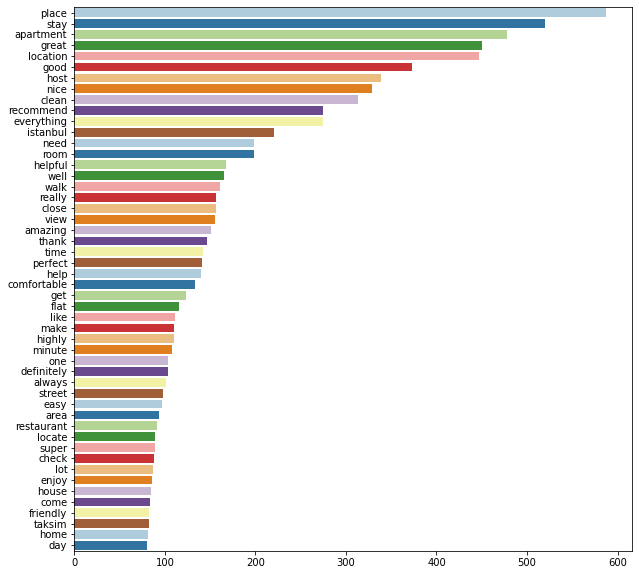

In [228]:
fdist = pd.Series(dict(FreqDist(process_2021).most_common(50)))
plt.figure(figsize=(10,10))
plot_nar = sns.barplot(y=fdist.index, x=fdist.values, palette="Paired")

'place', 'apartment', 'location', 'host', 'clean', 'helpful', 'view', 'comfortable', 'restaurant' and 'friendly' are the most frequency useful words in 2021 reviews. These words imply the concerns of customers: location of the room/house, host, cleanliness of the house/room, views, infrastructure around the house/room. And host can improve their room/house based on the conclusion thus they can get higher rating and they can set higher prices on Airbnb.

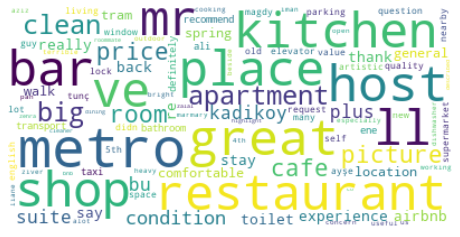

In [230]:
dictionary = Counter(process_2021)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(dictionary))
# Display the generated image:
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Wordcloud will remove some useless words automatically, and the top words after auto-cleaning are: bar, shop, restaurant, kitchen, host, metro, price and clean. These words imply the most obvious concerns of renters which are the infrastructures around the house/room, cleanliness, price and the host.